In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


print ('modules loaded')

modules loaded


In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [26]:
data_dir='/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    filpath=os.path.join(data_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series,l_series],axis=1)


In [27]:
strat=df['labels']
train_df,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [37]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(2951, 2)
(633, 2)
(633, 2)


In [44]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


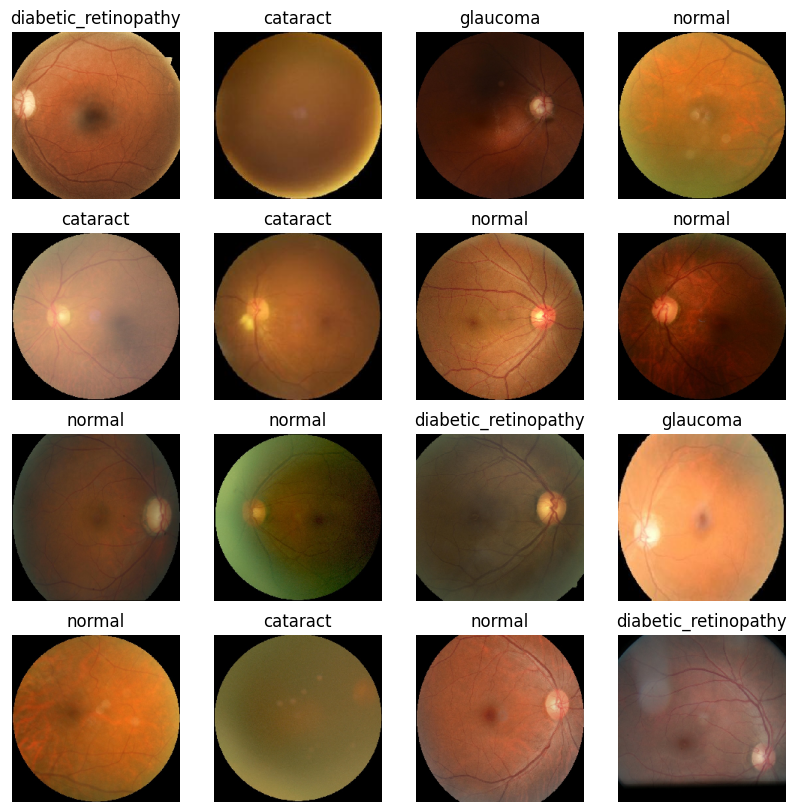

In [46]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

In [47]:
base_model=keras.applications.EfficientNetB3(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(4,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [48]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7180 - loss: 1.1990 - val_accuracy: 0.7393 - val_loss: 0.8610
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.9353 - loss: 0.1798 - val_accuracy: 0.8784 - val_loss: 0.3063
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - accuracy: 0.9741 - loss: 0.0838 - val_accuracy: 0.8878 - val_loss: 0.4050
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step - accuracy: 0.9815 - loss: 0.0564 - val_accuracy: 0.8957 - val_loss: 0.3710
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.9842 - loss: 0.0403 - val_accuracy: 0.9115 - val_loss: 0.3738
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - accuracy: 0.9832 - loss: 0.0357 - val_accuracy: 0.9100 - val_loss: 0.3980
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.9948 - loss: 0.0146 - val_accuracy: 0.9194 - val_loss: 0.4347
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 318ms/step - accuracy: 0.9889 - loss: 0.0428 - va

In [49]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step


In [50]:
print(y_pred)

[3 1 0 3 0 1 0 2 3 2 1 2 2 1 0 1 0 3 1 0 1 2 0 0 0 3 2 1 2 0 3 3 0 3 1 1 3
 3 1 0 2 1 3 0 1 0 1 3 3 2 3 2 0 2 2 3 1 2 1 3 2 1 2 1 0 1 2 1 0 1 2 0 1 3
 3 1 1 1 0 1 3 1 1 0 3 0 3 1 2 3 2 0 1 0 1 3 1 0 0 0 2 0 1 1 2 1 3 3 1 0 0
 2 1 3 3 3 2 3 0 0 1 3 3 0 2 3 1 0 0 0 3 3 1 1 0 0 0 2 1 1 0 2 0 1 3 2 3 3
 3 3 3 1 2 3 1 2 0 1 0 1 0 3 1 2 3 2 3 0 0 0 2 0 0 1 2 3 1 3 0 2 0 0 0 0 2
 3 2 3 1 3 2 1 3 1 3 3 2 3 0 3 1 1 2 3 3 2 0 2 0 0 0 0 1 2 3 2 0 1 1 1 3 3
 3 0 2 1 0 1 2 1 0 0 3 1 0 2 0 0 3 1 0 3 1 3 3 1 3 2 0 2 2 2 3 2 0 3 0 2 0
 1 3 3 0 1 2 3 2 3 1 0 2 3 3 2 1 1 1 3 0 1 3 3 0 2 0 1 3 1 2 2 1 1 1 2 2 0
 0 3 1 0 0 3 3 3 3 0 2 2 0 0 3 2 2 3 3 2 0 1 3 1 2 2 2 1 3 2 1 3 3 0 2 1 1
 1 2 2 2 0 0 1 2 1 1 0 2 0 2 1 1 2 0 2 1 3 2 3 3 2 3 1 1 3 3 2 0 2 2 3 3 2
 1 1 1 2 0 3 0 1 3 3 0 0 3 2 1 2 2 3 0 3 1 2 3 1 1 0 0 3 3 0 0 0 2 3 2 1 0
 0 1 0 3 2 3 3 0 0 2 3 1 3 0 2 3 2 3 0 2 1 2 1 2 1 2 2 0 0 1 2 1 1 0 3 3 2
 2 0 2 1 2 3 0 0 2 2 0 0 1 2 0 0 0 3 3 1 0 0 0 2 2 3 3 1 1 2 0 1 3 3 0 1 1
 1 0 0 3 3 3 3 0 0 3 2 2 

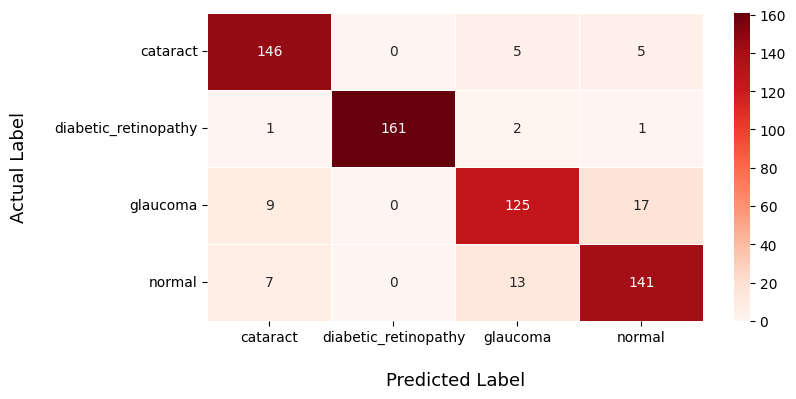

In [51]:
plt.figure(figsize=(8,4))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Reds", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);